In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import copy
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
df_lung = pd.read_csv('ACPs_Lung_cancer.csv')

In [3]:
df_lung.replace(['inactive - exp', 'inactive - virtual', 'mod. active', 'very active'], [0,0,1,2], inplace = True)

#Replace the inactive peptides with an activity of 0, the moderately active peptides with an activity of 1, and
#the very active peptides with an activity of 2.

In [4]:
def create_subsequence(seq, subseq_len):
    subsequences=[]
    for i in range(len(seq)):
        if i+subseq_len > len(seq):
            subsequences.append(0)
        else:
            subsequences.append(seq[i:i+subseq_len])
    return subsequences

#We define a function create_subsequence that takes peptide amino acid chain data and generates all subsequences 
#of a sequence of a predetermined length.

In [5]:
cols = [[] for x in range(12)]
for ind in df_lung.index:
    seq = df_lung['sequence'][ind]
    cancer_activity = df_lung['class'][ind]
    cols[0].extend([seq for x in range(len(seq))])
    cols[11].extend([cancer_activity for x in range(len(seq))])
    for i in range(1,11):
        cols[i].extend(create_subsequence(seq, i))


df_lung_subsequences_all = pd.DataFrame(list(zip(cols[0],cols[1],cols[2],cols[3],cols[4],cols[5],cols[6],cols[7],cols[8],cols[9],cols[10],cols[11])), columns=['Original Peptide','subsequence_1','subsequence_2','subsequence_3','subsequence_4','subsequence_5','subsequence_6','subsequence_7','subsequence_8','subsequence_9','subsequence_10','Cancer Activity'])

#We create a dataframe with all lung subsquences from length 1 to length 10. Because each peptide will have variable numbers
#of subsequences, we fill the data frame with zeros where there is no information. This is all peptide data.

In [6]:
df_lung_subsequences_all.head()

,Original Peptide,subsequence_1,subsequence_2,subsequence_3,subsequence_4,subsequence_5,subsequence_6,subsequence_7,subsequence_8,subsequence_9,subsequence_10,Cancer Activity
0,AIGKFLHSAKKFGKAFVGEIMNS,A,AI,AIG,AIGK,AIGKF,AIGKFL,AIGKFLH,AIGKFLHS,AIGKFLHSA,AIGKFLHSAK,1
1,AIGKFLHSAKKFGKAFVGEIMNS,I,IG,IGK,IGKF,IGKFL,IGKFLH,IGKFLHS,IGKFLHSA,IGKFLHSAK,IGKFLHSAKK,1
2,AIGKFLHSAKKFGKAFVGEIMNS,G,GK,GKF,GKFL,GKFLH,GKFLHS,GKFLHSA,GKFLHSAK,GKFLHSAKK,GKFLHSAKKF,1
3,AIGKFLHSAKKFGKAFVGEIMNS,K,KF,KFL,KFLH,KFLHS,KFLHSA,KFLHSAK,KFLHSAKK,KFLHSAKKF,KFLHSAKKFG,1
4,AIGKFLHSAKKFGKAFVGEIMNS,F,FL,FLH,FLHS,FLHSA,FLHSAK,FLHSAKK,FLHSAKKF,FLHSAKKFG,FLHSAKKFGK,1


In [7]:
array = df_lung_subsequences_all.to_numpy().tolist()

subchain_freq_all = {}
for i in range(1, 11):
    subchain_freq_all[i] = {}
    for j in range(len(array)):
        val = array[j][i]
        if val not in subchain_freq_all[i]:
            subchain_freq_all[i][val] = [1, 1, [array[j][0]]]
        else:
            if array[j][0] not in subchain_freq_all[i][val][2]:
                subchain_freq_all[i][val][0] = subchain_freq_all[i][val][0] + 1
                subchain_freq_all[i][val][1] = subchain_freq_all[i][val][1] + 1
                subchain_freq_all[i][val][2].append(array[j][0])
            else:
                subchain_freq_all[i][val][0] = subchain_freq_all[i][val][0] + 1                      
subchain_freq_lung_all = {}
for key1 in subchain_freq_all:
    subchain_freq_lung_all[key1] = []
    for key2 in subchain_freq_all[key1]:
        subchain_freq_lung_all[key1].append([key2, subchain_freq_all[key1][key2][0], subchain_freq_all[key1][key2][1]])
    subchain_freq_lung_all[key1] = sorted(subchain_freq_lung_all[key1], key = lambda x: x[1], reverse = True)
    for i in range(len(subchain_freq_lung_all[key1])-1):
        if subchain_freq_lung_all[key1][i][0] == 0:
            subchain_freq_lung_all[key1].remove(subchain_freq_lung_all[key1][i])
    
    
#Generates a dictionary with keys as the sequence length. Values are a list of lists. Each element in the list has a unique
#amino acid sequence at index 0, the number of times that element is observed at index 1, and the number of unique
#peptides that sequence is observed in at index 2. All lung peptides, organized from most to least prevalent.

In [8]:
df_lung_active = df_lung.loc[df_lung['class'] != 0]

cols = [[] for x in range(12)]
for ind in df_lung_active.index:
    seq = df_lung_active['sequence'][ind]
    cancer_activity = df_lung_active['class'][ind]
    cols[0].extend([seq for x in range(len(seq))])
    cols[11].extend([cancer_activity for x in range(len(seq))])
    for i in range(1,11):
        cols[i].extend(create_subsequence(seq, i))
        
df_lung_subsequences_active = pd.DataFrame(list(zip(cols[0],cols[1],cols[2],cols[3],cols[4],cols[5],cols[6],cols[7],cols[8],cols[9],cols[10],cols[11])), columns=['Original Peptide','subsequence_1','subsequence_2','subsequence_3','subsequence_4','subsequence_5','subsequence_6','subsequence_7','subsequence_8','subsequence_9','subsequence_10','Cancer Activity'])

#Split the dataframe into only the peptides that had some cancer activity.

In [9]:
array = df_lung_subsequences_active.to_numpy().tolist()

subchain_freq = {}
for i in range(1, 11):
    subchain_freq[i] = {}
    for j in range(len(array)):
        val = array[j][i]
        if val not in subchain_freq[i]:
            subchain_freq[i][val] = [1, 1, [array[j][0]]]
        else:
            if array[j][0] not in subchain_freq[i][val][2]:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1
                subchain_freq[i][val][1] = subchain_freq[i][val][1] + 1
                subchain_freq[i][val][2].append(array[j][0])
            else:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1                      
subchain_freq_lung_active = {}
for key1 in subchain_freq:
    subchain_freq_lung_active[key1] = []
    for key2 in subchain_freq[key1]:
        subchain_freq_lung_active[key1].append([key2, subchain_freq[key1][key2][0], subchain_freq[key1][key2][1]])
    subchain_freq_lung_active[key1] = sorted(subchain_freq_lung_active[key1], key = lambda x: x[1], reverse = True)
    for i in range(len(subchain_freq_lung_active[key1])-1):
        if subchain_freq_lung_active[key1][i][0] == 0:
            subchain_freq_lung_active[key1].remove(subchain_freq_lung_active[key1][i])
    
    
#Generates a dictionary with keys as the sequence length. Values are a list of lists. Each element in the list has a unique
#amino acid sequence at index 0, the number of times that element is observed at index 1, and the number of unique
#peptides that sequence is observed in at index 2. All active lung peptides, organized from most to least prevalent.

In [10]:
df_lung_inactive = df_lung.loc[df_lung['class'] == 0]

cols = [[] for x in range(12)]
for ind in df_lung_inactive.index:
    seq = df_lung_inactive['sequence'][ind]
    cancer_activity = df_lung_inactive['class'][ind]
    cols[0].extend([seq for x in range(len(seq))])
    cols[11].extend([cancer_activity for x in range(len(seq))])
    for i in range(1,11):
        cols[i].extend(create_subsequence(seq, i))
        
df_lung_subsequences_inactive = pd.DataFrame(list(zip(cols[0],cols[1],cols[2],cols[3],cols[4],cols[5],cols[6],cols[7],cols[8],cols[9],cols[10],cols[11])), columns=['Original Peptide','subsequence_1','subsequence_2','subsequence_3','subsequence_4','subsequence_5','subsequence_6','subsequence_7','subsequence_8','subsequence_9','subsequence_10','Cancer Activity'])
        
#Split the dataframe into only the peptides that had no cancer activity.

In [11]:
df_lung_subsequences_inactive.head()

,Original Peptide,subsequence_1,subsequence_2,subsequence_3,subsequence_4,subsequence_5,subsequence_6,subsequence_7,subsequence_8,subsequence_9,subsequence_10,Cancer Activity
0,FAKIIAKIAKIAKKIL,F,FA,FAK,FAKI,FAKII,FAKIIA,FAKIIAK,FAKIIAKI,FAKIIAKIA,FAKIIAKIAK,0
1,FAKIIAKIAKIAKKIL,A,AK,AKI,AKII,AKIIA,AKIIAK,AKIIAKI,AKIIAKIA,AKIIAKIAK,AKIIAKIAKI,0
2,FAKIIAKIAKIAKKIL,K,KI,KII,KIIA,KIIAK,KIIAKI,KIIAKIA,KIIAKIAK,KIIAKIAKI,KIIAKIAKIA,0
3,FAKIIAKIAKIAKKIL,I,II,IIA,IIAK,IIAKI,IIAKIA,IIAKIAK,IIAKIAKI,IIAKIAKIA,IIAKIAKIAK,0
4,FAKIIAKIAKIAKKIL,I,IA,IAK,IAKI,IAKIA,IAKIAK,IAKIAKI,IAKIAKIA,IAKIAKIAK,IAKIAKIAKK,0


In [12]:
array = df_lung_subsequences_inactive.to_numpy().tolist()

subchain_freq = {}
for i in range(1, 11):
    subchain_freq[i] = {}
    for j in range(len(array)):
        val = array[j][i]
        if val not in subchain_freq[i]:
            subchain_freq[i][val] = [1, 1, [array[j][0]]]
        else:
            if array[j][0] not in subchain_freq[i][val][2]:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1
                subchain_freq[i][val][1] = subchain_freq[i][val][1] + 1
                subchain_freq[i][val][2].append(array[j][0])
            else:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1                      
subchain_freq_lung_inactive = {}
for key1 in subchain_freq:
    subchain_freq_lung_inactive[key1] = []
    for key2 in subchain_freq[key1]:
        subchain_freq_lung_inactive[key1].append([key2, subchain_freq[key1][key2][0], subchain_freq[key1][key2][1]])
    subchain_freq_lung_inactive[key1] = sorted(subchain_freq_lung_inactive[key1], key = lambda x: x[1], reverse = True)
    for i in range(len(subchain_freq_lung_inactive[key1])-1):
        if subchain_freq_lung_inactive[key1][i][0] == 0:
            subchain_freq_lung_inactive[key1].remove(subchain_freq_lung_inactive[key1][i])

subchain_freq_lung_inactive[1].append(['C', 0, 0])
    
    
#Generates a dictionary with keys as the sequence length. Values are a list of lists. Each element in the list has a unique
#amino acid sequence at index 0, the number of times that element is observed at index 1, and the number of unique
#peptides that sequence is observed in at index 2. All inactive lung peptides, organized from most to least prevalent.

In [13]:
data = []
total_lung_subchains_dict = {}
total_active_lung_subchains_dict = {}
total_active_lung_peptides = 99
total_inactive_lung_peptides = 802
total_lung_peptides = 901
for key in subchain_freq_lung_all:
    total_lung_subchains = 0
    for val in subchain_freq_lung_all[key]:
        total_lung_subchains += val[1]
    total_lung_subchains_dict[key] = total_lung_subchains

for key in subchain_freq_lung_active:
    total_active_lung_subchains = 0
    for val in subchain_freq_lung_active[key]:
        total_active_lung_subchains += val[1]
    total_active_lung_subchains_dict[key] = total_active_lung_subchains    
    
for key in subchain_freq_lung_active:
    for i in range(20):
        data_list = copy.deepcopy(subchain_freq_lung_active[key][i])
        data_list.append(subchain_freq_lung_active[key][i][1]/total_active_lung_subchains_dict[key])
        data_list.append(subchain_freq_lung_active[key][i][2]/total_active_lung_peptides)
        data_list.append(subchain_freq_all[key][subchain_freq_lung_active[key][i][0]][0]/total_lung_subchains_dict[key])
        data_list.append(subchain_freq_all[key][subchain_freq_lung_active[key][i][0]][1]/total_lung_peptides)
        data.append(data_list)
df_lung_active_all_data = pd.DataFrame(data, columns = ['Amino Acid Sequence', 'Times Oberserved', 'Unique Peptides Present In', 'Percent of Active Chains','Percent of Active Peptides', 'Percent of Total Chains', 'Percent of Total Peptides'])

#Aggregate the all the lung data. Creates a dataframe that has the 20 most common subchains of each length, how many times
#each subchain is observed, how many unique peptides the subchain is present in, the percent of all active chains this subchain
#represents, the percent of active peptides that has this subchain, the percent of all chains (active + inactive) this 
#subchain is in, and the percent of all peptides this subchain is in.

In [68]:
df_lung_active_all_data.head()

,Amino Acid Sequence,Times Oberserved,Unique Peptides Present In,Percent of Active Chains,Percent of Active Peptides,Percent of Total Chains,Percent of Total Peptides
0,K,512,98,0.279934,0.989899,0.108471,0.713651
1,L,327,95,0.178786,0.959596,0.134426,0.884573
2,A,259,95,0.141607,0.959596,0.112785,0.806881
3,F,169,95,0.092400,0.959596,0.050916,0.578246
4,I,113,55,0.061782,0.555556,0.061338,0.613762


In [15]:
data = []
total_lung_subchains_dict = {}
total_inactive_lung_subchains_dict = {}
total_active_lung_peptides = 99
total_inactive_lung_peptides = 802
total_lung_peptides = 901
for key in subchain_freq_lung_all:
    total_lung_subchains = 0
    for val in subchain_freq_lung_all[key]:
        total_lung_subchains += val[1]
    total_lung_subchains_dict[key] = total_lung_subchains

for key in subchain_freq_lung_inactive:
    total_inactive_lung_subchains = 0
    for val in subchain_freq_lung_inactive[key]:
        total_inactive_lung_subchains += val[1]
    total_inactive_lung_subchains_dict[key] = total_inactive_lung_subchains    
    
for key in subchain_freq_lung_inactive:
    for i in range(20):
        data_list = copy.deepcopy(subchain_freq_lung_inactive[key][i])
        data_list.append(subchain_freq_lung_inactive[key][i][1]/total_inactive_lung_subchains_dict[key])
        data_list.append(subchain_freq_lung_inactive[key][i][2]/total_inactive_lung_peptides)
        data_list.append(subchain_freq_all[key][subchain_freq_lung_inactive[key][i][0]][0]/total_lung_subchains_dict[key])
        data_list.append(subchain_freq_all[key][subchain_freq_lung_inactive[key][i][0]][1]/total_lung_peptides)
        data.append(data_list)
df_lung_inactive_all_data = pd.DataFrame(data, columns = ['Amino Acid Sequence', 'Times Oberserved', 'Unique Peptides Present In', 'Percent of Inactive Chains','Percent of Inactive Peptides', 'Percent of Total Chains', 'Percent of Total Peptides'])

#Aggregate the all the lung data. Creates a dataframe that has the 20 most common subchains of each length, how many times
#each subchain is observed, how many unique peptides the subchain is present in, the percent of all inactive chains this subchain
#represents, the percent of inactive peptides that has this subchain, the percent of all chains (active + inactive) this 
#subchain is in, and the percent of all peptides this subchain is in.

In [16]:
df_lung_inactive_all_data.head()

,Amino Acid Sequence,Times Oberserved,Unique Peptides Present In,Percent of Inactive Chains,Percent of Inactive Peptides,Percent of Total Chains,Percent of Total Peptides
0,L,1698,702,0.128296,0.875312,0.134426,0.884573
1,A,1440,632,0.108802,0.788030,0.112785,0.806881
2,K,1122,545,0.084775,0.679551,0.108471,0.713651
3,E,1063,551,0.080317,0.687032,0.071030,0.618202
4,V,815,498,0.061579,0.620948,0.059944,0.603774


In [17]:
df_lung_active_plot = df_lung_active_all_data[['Amino Acid Sequence','Percent of Active Peptides', 'Percent of Total Peptides']]

array = df_lung_active_plot.to_numpy().tolist()
new_array = []
for i in range(len(array)):
    new_array.append([array[i][0], 'Percent of Active Peptides', array[i][1]])
    new_array.append([array[i][0], 'Percent of Total Peptides', array[i][2]])
df_lung_active_plot = pd.DataFrame(new_array, columns = ['Amino Acid Sequence', 'Peptide Info', 'Percent'])

#Organize the active peptide data into a format that can be graphed as a countplot comparing the percent of active peptides
#the subsequence is present in, vs the percent of total peptides the subsequence is present in.

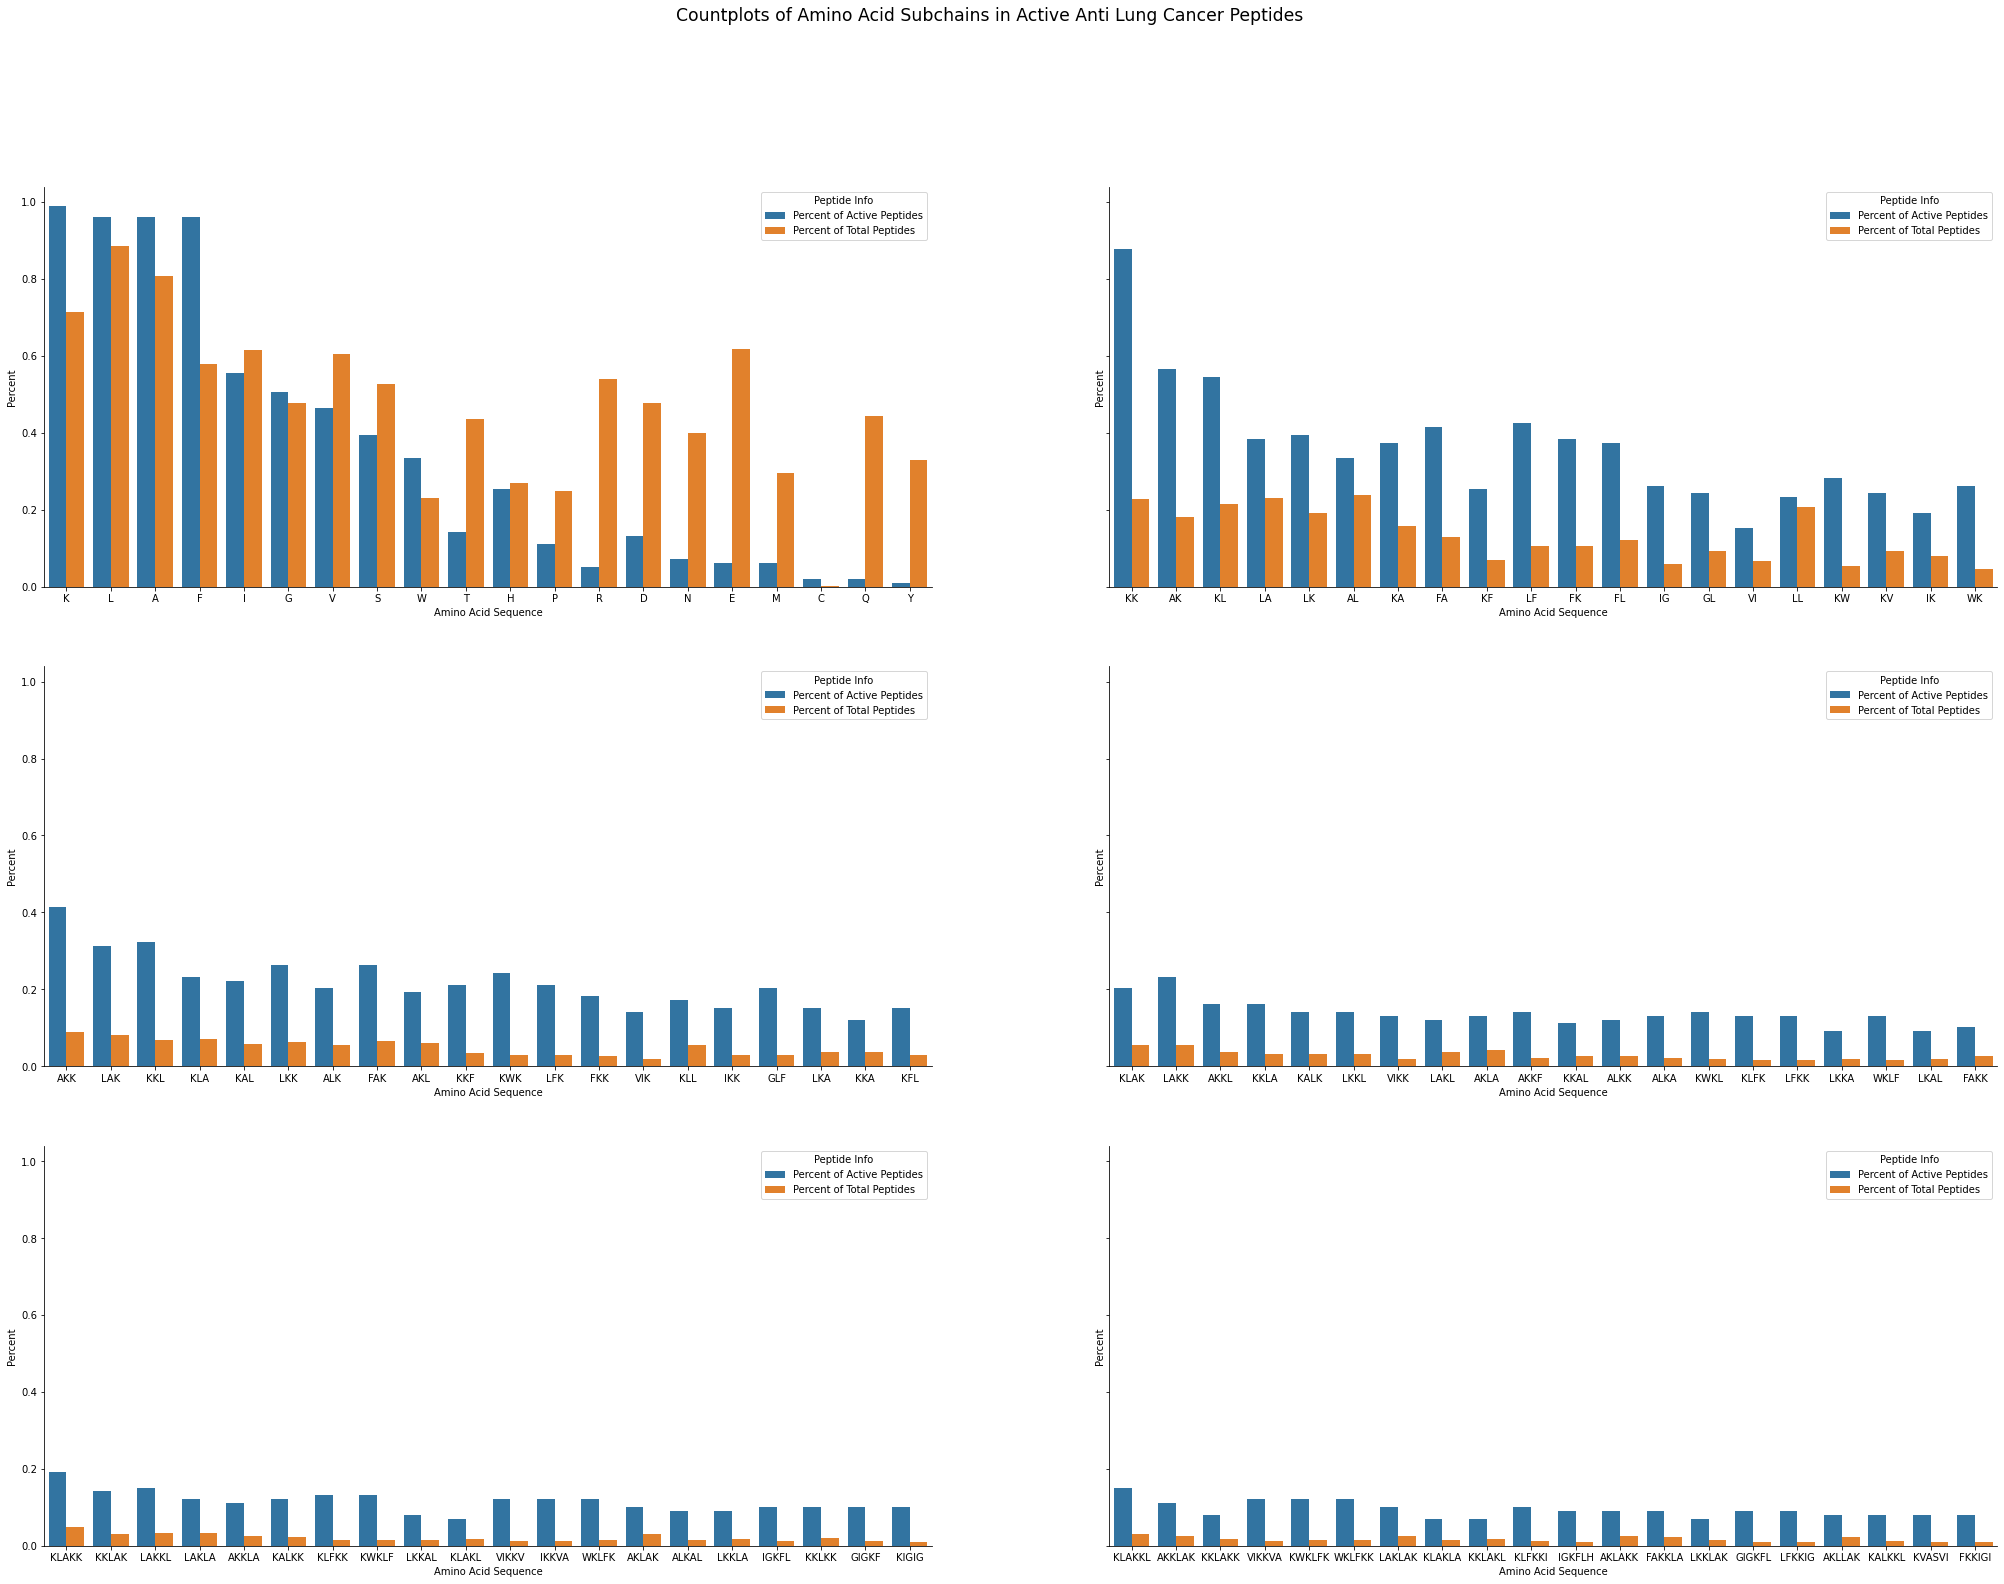

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 2, nrows = 3, figsize=(35, 25), sharey = True)
fig.suptitle('Countplots of Amino Acid Subchains in Active Anti Lung Cancer Peptides', size = 'xx-large')
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_active_plot[:40], ax=ax1[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_active_plot[40:80], ax=ax1[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_active_plot[80:120], ax=ax2[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_active_plot[120:160], ax=ax2[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_active_plot[160:200], ax=ax3[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_active_plot[200:240], ax=ax3[1])
sns.despine(fig)

#Plots the 20 most common subsequences of lengths 1 to 6 in order to compare prevalency in active peptides vs prevalency
#in all peptides. Past subsequences of length 6, the occurence of a specific chain is too low to draw any inferences.

In [19]:
df_lung_inactive_plot = df_lung_inactive_all_data[['Amino Acid Sequence','Percent of Inactive Peptides', 'Percent of Total Peptides']]

array = df_lung_inactive_plot.to_numpy().tolist()
new_array = []
for i in range(len(array)):
    new_array.append([array[i][0], 'Percent of Inactive Peptides', array[i][1]])
    new_array.append([array[i][0], 'Percent of Total Peptides', array[i][2]])
df_lung_inactive_plot = pd.DataFrame(new_array, columns = ['Amino Acid Sequence', 'Peptide Info', 'Percent'])

#Organize the inactive peptide data into a format that can be graphed as a countplot comparing the percent of inactive peptides
#the subsequence is present in, vs the percent of total peptides the subsequence is present in.

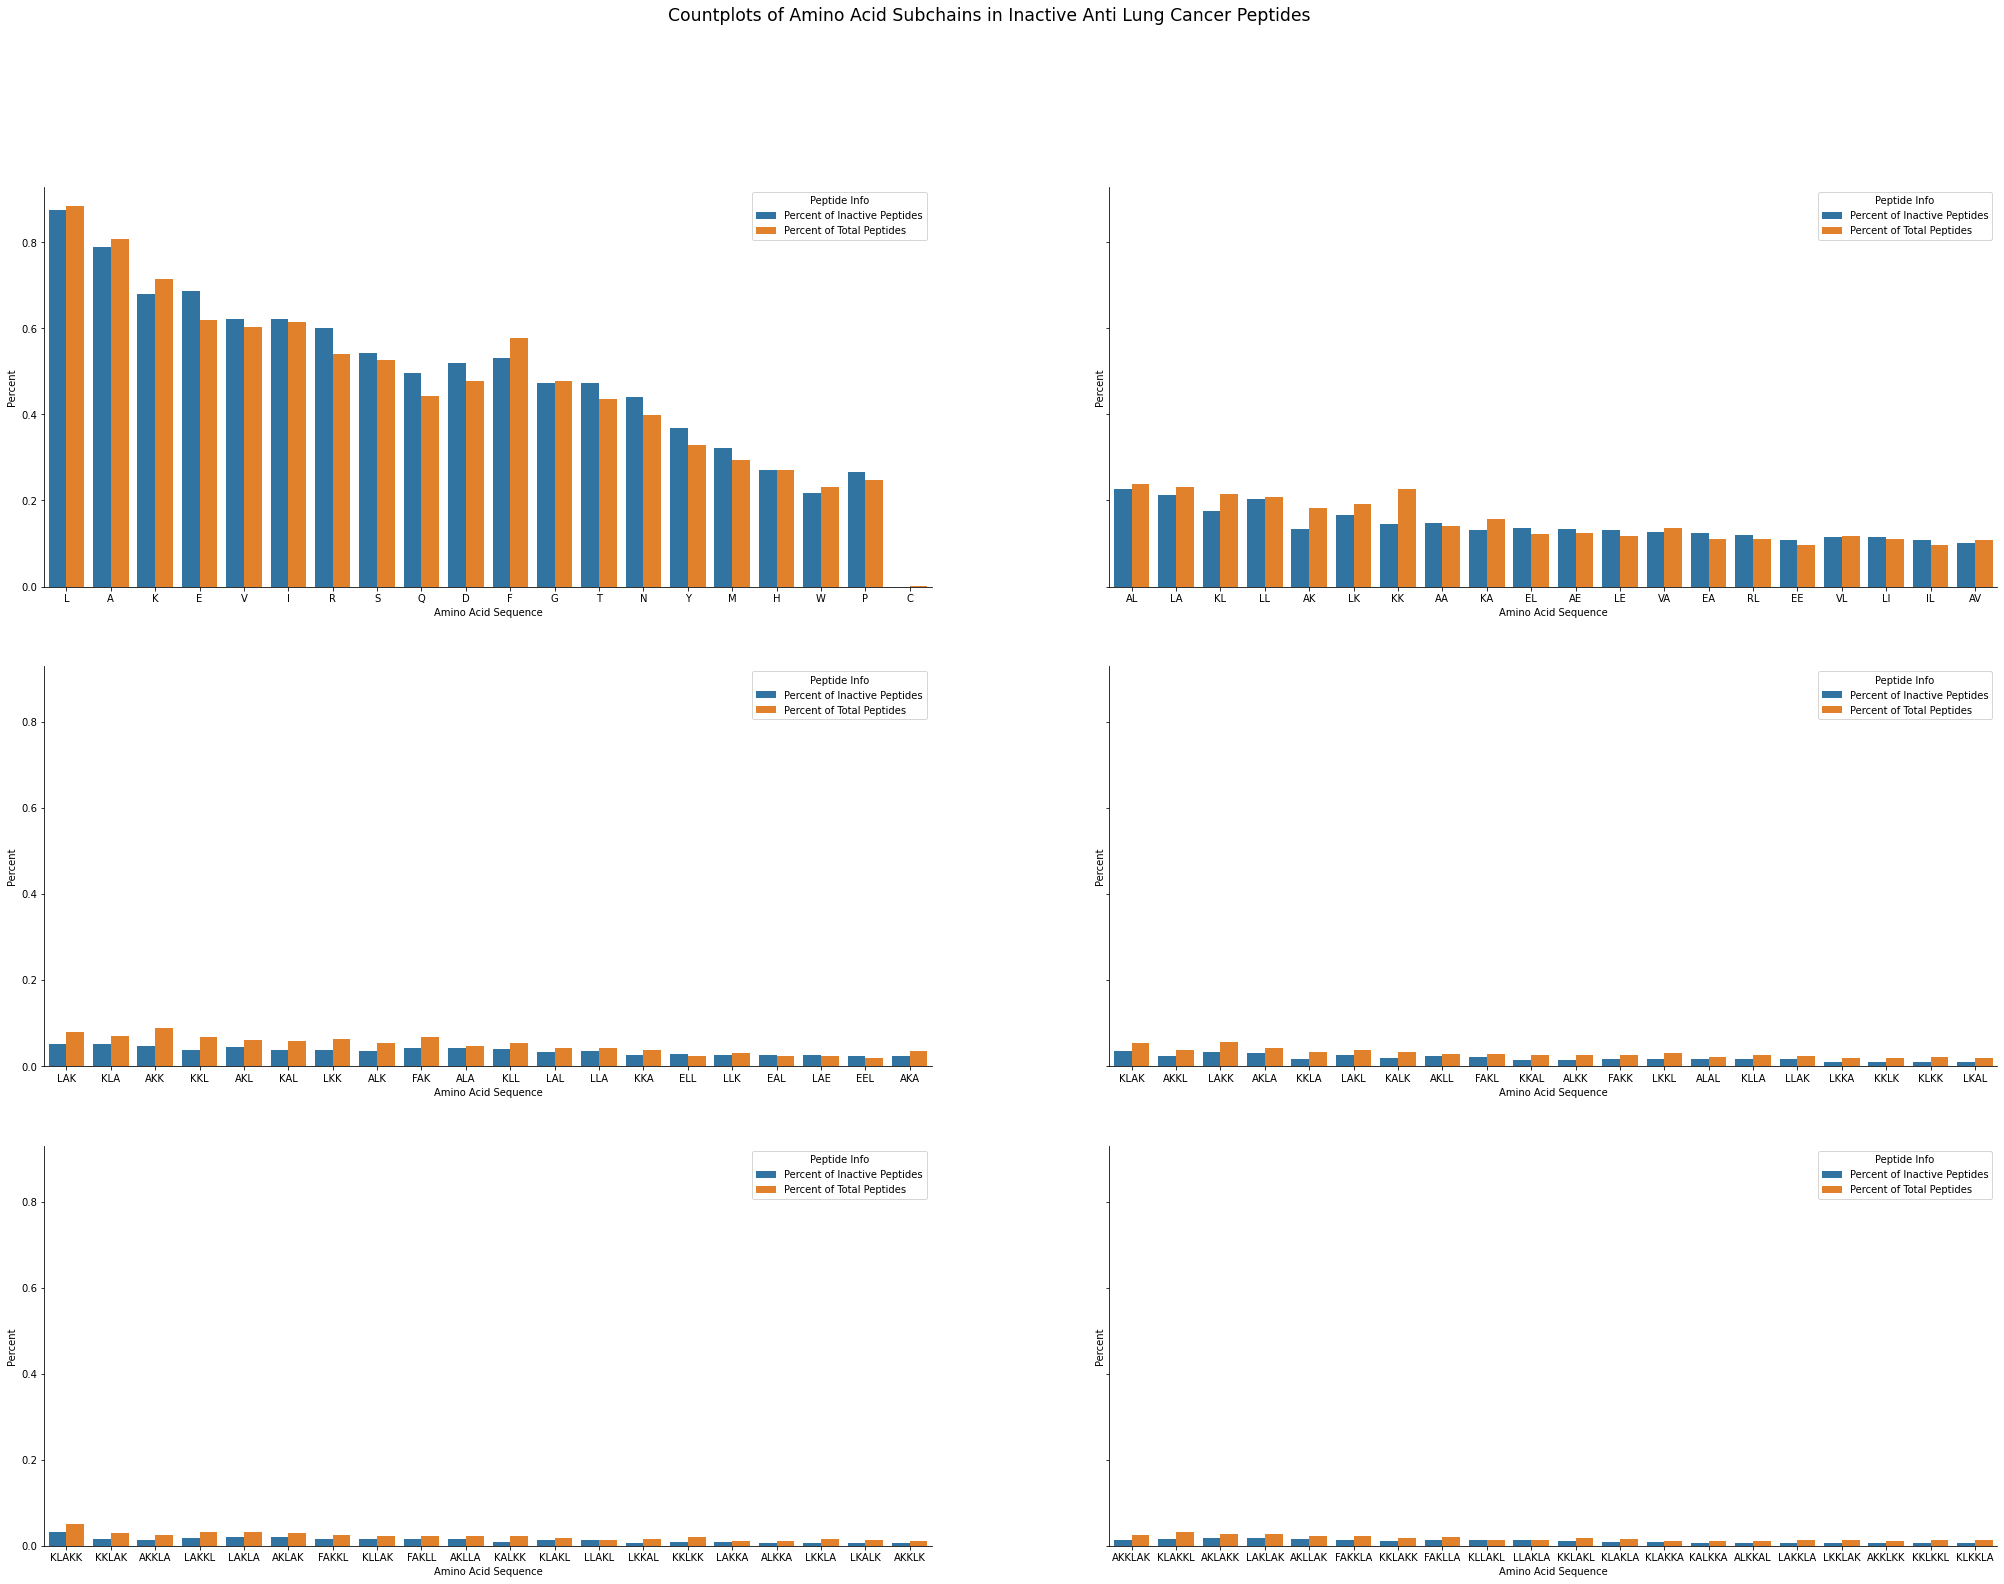

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 2, nrows = 3, figsize=(35, 25), sharey = True)
fig.suptitle('Countplots of Amino Acid Subchains in Inactive Anti Lung Cancer Peptides', size = 'xx-large')
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_inactive_plot[:40], ax=ax1[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_inactive_plot[40:80], ax=ax1[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_inactive_plot[80:120], ax=ax2[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_inactive_plot[120:160], ax=ax2[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_inactive_plot[160:200], ax=ax3[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_lung_inactive_plot[200:240], ax=ax3[1])
sns.despine(fig)

#Plots the 20 most common subsequences of lengths 1 to 6 in order to compare prevalency in active peptides vs prevalency
#in all peptides. Past subsequences of length 6, the occurence of a specific chain is too low to draw any inferences.

In [21]:
df_breast = pd.read_csv('ACPs_Breast_cancer.csv')

#Repeat the process with breast cancer data.

In [22]:
df_breast.replace(['inactive - exp', 'inactive - virtual', 'mod. active', 'very active'], [0,0,1,2], inplace = True)

In [23]:
array = df_breast.to_numpy().tolist()
for i in range(len(array)):
    for let in array[i][1]:
        if let.islower():
            array[i][1] = array[i][1].upper()
df_breast = pd.DataFrame(array, columns = ['ID', 'sequence', 'class'])

#The breast cancer data had some sequences with lowercase letters that needed to be transformed into uppercase letters.

In [24]:
cols = [[] for x in range(12)]
for ind in df_breast.index:
    seq = df_breast['sequence'][ind]
    cancer_activity = df_breast['class'][ind]
    cols[0].extend([seq for x in range(len(seq))])
    cols[11].extend([cancer_activity for x in range(len(seq))])
    for i in range(1,11):
        cols[i].extend(create_subsequence(seq, i))
        
df_breast_subsequences_all = pd.DataFrame(list(zip(cols[0],cols[1],cols[2],cols[3],cols[4],cols[5],cols[6],cols[7],cols[8],cols[9],cols[10],cols[11])), columns=['Original Peptide','subsequence_1','subsequence_2','subsequence_3','subsequence_4','subsequence_5','subsequence_6','subsequence_7','subsequence_8','subsequence_9','subsequence_10','Cancer Activity'])

#We create a dataframe with all breast subsquences from length 1 to length 10. Because each peptide will have variable numbers
#of subsequences, we fill the data frame with zeros where there is no information. This is all peptide data.

In [25]:
array = df_breast_subsequences_all.to_numpy().tolist()

subchain_freq_all = {}
for i in range(1, 11):
    subchain_freq_all[i] = {}
    for j in range(len(array)):
        val = array[j][i]
        if val not in subchain_freq_all[i]:
            subchain_freq_all[i][val] = [1, 1, [array[j][0]]]
        else:
            if array[j][0] not in subchain_freq_all[i][val][2]:
                subchain_freq_all[i][val][0] = subchain_freq_all[i][val][0] + 1
                subchain_freq_all[i][val][1] = subchain_freq_all[i][val][1] + 1
                subchain_freq_all[i][val][2].append(array[j][0])
            else:
                subchain_freq_all[i][val][0] = subchain_freq_all[i][val][0] + 1                      
subchain_freq_breast_all = {}
for key1 in subchain_freq_all:
    subchain_freq_breast_all[key1] = []
    for key2 in subchain_freq_all[key1]:
        subchain_freq_breast_all[key1].append([key2, subchain_freq_all[key1][key2][0], subchain_freq_all[key1][key2][1]])
    subchain_freq_breast_all[key1] = sorted(subchain_freq_breast_all[key1], key = lambda x: x[1], reverse = True)
    for i in range(len(subchain_freq_breast_all[key1])-1):
        if subchain_freq_breast_all[key1][i][0] == 0:
            subchain_freq_breast_all[key1].remove(subchain_freq_breast_all[key1][i])
    
    
#Generates a dictionary with keys as the sequence length. Values are a list of lists. Each element in the list has a unique
#amino acid sequence at index 0, the number of times that element is observed at index 1, and the number of unique
#peptides that sequence is observed in at index 2. All breast peptides, organized from most to least prevalent.

In [26]:
df_breast_active = df_breast.loc[df_breast['class'] != 0]

cols = [[] for x in range(12)]
for ind in df_breast_active.index:
    seq = df_breast_active['sequence'][ind]
    cancer_activity = df_breast_active['class'][ind]
    cols[0].extend([seq for x in range(len(seq))])
    cols[11].extend([cancer_activity for x in range(len(seq))])
    for i in range(1,11):
        cols[i].extend(create_subsequence(seq, i))
        
df_breast_subsequences_active = pd.DataFrame(list(zip(cols[0],cols[1],cols[2],cols[3],cols[4],cols[5],cols[6],cols[7],cols[8],cols[9],cols[10],cols[11])), columns=['Original Peptide','subsequence_1','subsequence_2','subsequence_3','subsequence_4','subsequence_5','subsequence_6','subsequence_7','subsequence_8','subsequence_9','subsequence_10','Cancer Activity'])

#Split the dataframe into only the peptides that had some cancer activity.

In [27]:
array = df_breast_subsequences_active.to_numpy().tolist()

subchain_freq = {}
for i in range(1, 11):
    subchain_freq[i] = {}
    for j in range(len(array)):
        val = array[j][i]
        if val not in subchain_freq[i]:
            subchain_freq[i][val] = [1, 1, [array[j][0]]]
        else:
            if array[j][0] not in subchain_freq[i][val][2]:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1
                subchain_freq[i][val][1] = subchain_freq[i][val][1] + 1
                subchain_freq[i][val][2].append(array[j][0])
            else:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1                      
subchain_freq_breast_active = {}
for key1 in subchain_freq:
    subchain_freq_breast_active[key1] = []
    for key2 in subchain_freq[key1]:
        subchain_freq_breast_active[key1].append([key2, subchain_freq[key1][key2][0], subchain_freq[key1][key2][1]])
    subchain_freq_breast_active[key1] = sorted(subchain_freq_breast_active[key1], key = lambda x: x[1], reverse = True)
    for i in range(len(subchain_freq_breast_active[key1])-1):
        if subchain_freq_breast_active[key1][i][0] == 0:
            subchain_freq_breast_active[key1].remove(subchain_freq_breast_active[key1][i])
    
    
#Generates a dictionary with keys as the sequence length. Values are a list of lists. Each element in the list has a unique
#amino acid sequence at index 0, the number of times that element is observed at index 1, and the number of unique
#peptides that sequence is observed in at index 2. All active breast peptides, organized from most to least prevalent.

In [28]:
df_breast_inactive = df_breast.loc[df_breast['class'] == 0]

cols = [[] for x in range(12)]
for ind in df_breast_inactive.index:
    seq = df_breast_inactive['sequence'][ind]
    cancer_activity = df_breast_inactive['class'][ind]
    cols[0].extend([seq for x in range(len(seq))])
    cols[11].extend([cancer_activity for x in range(len(seq))])
    for i in range(1,11):
        cols[i].extend(create_subsequence(seq, i))
        
df_breast_subsequences_inactive = pd.DataFrame(list(zip(cols[0],cols[1],cols[2],cols[3],cols[4],cols[5],cols[6],cols[7],cols[8],cols[9],cols[10],cols[11])), columns=['Original Peptide','subsequence_1','subsequence_2','subsequence_3','subsequence_4','subsequence_5','subsequence_6','subsequence_7','subsequence_8','subsequence_9','subsequence_10','Cancer Activity'])

#Split the dataframe into only the peptides that had no cancer activity.

In [29]:
array = df_breast_subsequences_inactive.to_numpy().tolist()

subchain_freq = {}
for i in range(1, 11):
    subchain_freq[i] = {}
    for j in range(len(array)):
        val = array[j][i]
        if val not in subchain_freq[i]:
            subchain_freq[i][val] = [1, 1, [array[j][0]]]
        else:
            if array[j][0] not in subchain_freq[i][val][2]:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1
                subchain_freq[i][val][1] = subchain_freq[i][val][1] + 1
                subchain_freq[i][val][2].append(array[j][0])
            else:
                subchain_freq[i][val][0] = subchain_freq[i][val][0] + 1                      
subchain_freq_breast_inactive = {}
for key1 in subchain_freq:
    subchain_freq_breast_inactive[key1] = []
    for key2 in subchain_freq[key1]:
        subchain_freq_breast_inactive[key1].append([key2, subchain_freq[key1][key2][0], subchain_freq[key1][key2][1]])
    subchain_freq_breast_inactive[key1] = sorted(subchain_freq_breast_inactive[key1], key = lambda x: x[1], reverse = True)
    for i in range(len(subchain_freq_breast_inactive[key1])-1):
        if subchain_freq_breast_inactive[key1][i][0] == 0:
            subchain_freq_breast_inactive[key1].remove(subchain_freq_breast_inactive[key1][i])

subchain_freq_breast_inactive[1].append(['C', 0, 0])
            
    
#Generates a dictionary with keys as the sequence length. Values are a list of lists. Each element in the list has a unique
#amino acid sequence at index 0, the number of times that element is observed at index 1, and the number of unique
#peptides that sequence is observed in at index 2. All inactive breast peptides, organized from most to least prevalent.

In [30]:
data = []
total_breast_subchains_dict = {}
total_active_breast_subchains_dict = {}
total_active_breast_peptides = 116
total_inactive_breast_peptides = 833
total_breast_peptides = 949
for key in subchain_freq_breast_all:
    total_breast_subchains = 0
    for val in subchain_freq_breast_all[key]:
        total_breast_subchains += val[1]
    total_breast_subchains_dict[key] = total_breast_subchains

for key in subchain_freq_breast_active:
    total_active_breast_subchains = 0
    for val in subchain_freq_breast_active[key]:
        total_active_breast_subchains += val[1]
    total_active_breast_subchains_dict[key] = total_active_breast_subchains    
    
for key in subchain_freq_breast_active:
    for i in range(20):
        data_list = copy.deepcopy(subchain_freq_breast_active[key][i])
        data_list.append(subchain_freq_breast_active[key][i][1]/total_active_breast_subchains_dict[key])
        data_list.append(subchain_freq_breast_active[key][i][2]/total_active_breast_peptides)
        data_list.append(subchain_freq_all[key][subchain_freq_breast_active[key][i][0]][0]/total_breast_subchains_dict[key])
        data_list.append(subchain_freq_all[key][subchain_freq_breast_active[key][i][0]][1]/total_breast_peptides)
        data.append(data_list)
df_breast_active_all_data = pd.DataFrame(data, columns = ['Amino Acid Sequence', 'Times Oberserved', 'Unique Peptides Present In', 'Percent of Active Chains','Percent of Active Peptides', 'Percent of Total Chains', 'Percent of Total Peptides'])

#Aggregate the all the breast data. Creates a dataframe that has the 20 most common subchains of each length, how many times
#each subchain is observed, how many unique peptides the subchain is present in, the percent of all active chains this subchain
#represents, the percent of active peptides that has this subchain, the percent of all chains (active + inactive) this 
#subchain is in, and the percent of all peptides this subchain is in.

In [70]:
df_breast_active_all_data.head()

,Amino Acid Sequence,Times Oberserved,Unique Peptides Present In,Percent of Active Chains,Percent of Active Peptides,Percent of Total Chains,Percent of Total Peptides
0,K,614,113,0.284787,0.974138,0.118421,0.724974
1,L,393,105,0.182282,0.905172,0.136364,0.877766
2,A,329,104,0.152597,0.896552,0.117414,0.801897
3,F,170,99,0.078850,0.853448,0.050932,0.577450
4,I,103,56,0.047774,0.482759,0.058612,0.595364


In [32]:
data = []
total_breast_subchains_dict = {}
total_inactive_breast_subchains_dict = {}
total_active_breast_peptides = 116
total_inactive_breast_peptides = 833
total_breast_peptides = 949
for key in subchain_freq_breast_all:
    total_breast_subchains = 0
    for val in subchain_freq_breast_all[key]:
        total_breast_subchains += val[1]
    total_breast_subchains_dict[key] = total_breast_subchains

for key in subchain_freq_breast_inactive:
    total_inactive_breast_subchains = 0
    for val in subchain_freq_breast_inactive[key]:
        total_inactive_breast_subchains += val[1]
    total_inactive_breast_subchains_dict[key] = total_inactive_breast_subchains    
    
for key in subchain_freq_breast_inactive:
    for i in range(20):
        data_list = copy.deepcopy(subchain_freq_breast_inactive[key][i])
        data_list.append(subchain_freq_breast_inactive[key][i][1]/total_inactive_breast_subchains_dict[key])
        data_list.append(subchain_freq_breast_inactive[key][i][2]/total_inactive_breast_peptides)
        data_list.append(subchain_freq_all[key][subchain_freq_breast_inactive[key][i][0]][0]/total_breast_subchains_dict[key])
        data_list.append(subchain_freq_all[key][subchain_freq_breast_inactive[key][i][0]][1]/total_breast_peptides)
        data.append(data_list)
df_breast_inactive_all_data = pd.DataFrame(data, columns = ['Amino Acid Sequence', 'Times Oberserved', 'Unique Peptides Present In', 'Percent of Inactive Chains','Percent of Inactive Peptides', 'Percent of Total Chains', 'Percent of Total Peptides'])

#Aggregate the all the breast data. Creates a dataframe that has the 20 most common subchains of each length, how many times
#each subchain is observed, how many unique peptides the subchain is present in, the percent of all inactive chains this subchain
#represents, the percent of inactive peptides that has this subchain, the percent of all chains (active + inactive) this 
#subchain is in, and the percent of all peptides this subchain is in.

In [33]:
df_breast_inactive_all_data.head()

,Amino Acid Sequence,Times Oberserved,Unique Peptides Present In,Percent of Inactive Chains,Percent of Inactive Peptides,Percent of Total Chains,Percent of Total Peptides
0,L,1773,728,0.129152,0.873950,0.136364,0.877766
1,A,1536,657,0.111888,0.788715,0.117414,0.801897
2,K,1267,575,0.092293,0.690276,0.118421,0.724974
3,E,1063,551,0.077433,0.661465,0.068308,0.594310
4,V,831,510,0.060533,0.612245,0.057857,0.584826


In [34]:
df_breast_active_plot = df_breast_active_all_data[['Amino Acid Sequence','Percent of Active Peptides', 'Percent of Total Peptides']]

array = df_breast_active_plot.to_numpy().tolist()
new_array = []
for i in range(len(array)):
    new_array.append([array[i][0], 'Percent of Active Peptides', array[i][1]])
    new_array.append([array[i][0], 'Percent of Total Peptides', array[i][2]])
df_breast_active_plot = pd.DataFrame(new_array, columns = ['Amino Acid Sequence', 'Peptide Info', 'Percent'])

#Organize the active peptide data into a format that can be graphed as a countplot comparing the percent of active peptides
#the subsequence is present in, vs the percent of total peptides the subsequence is present in.

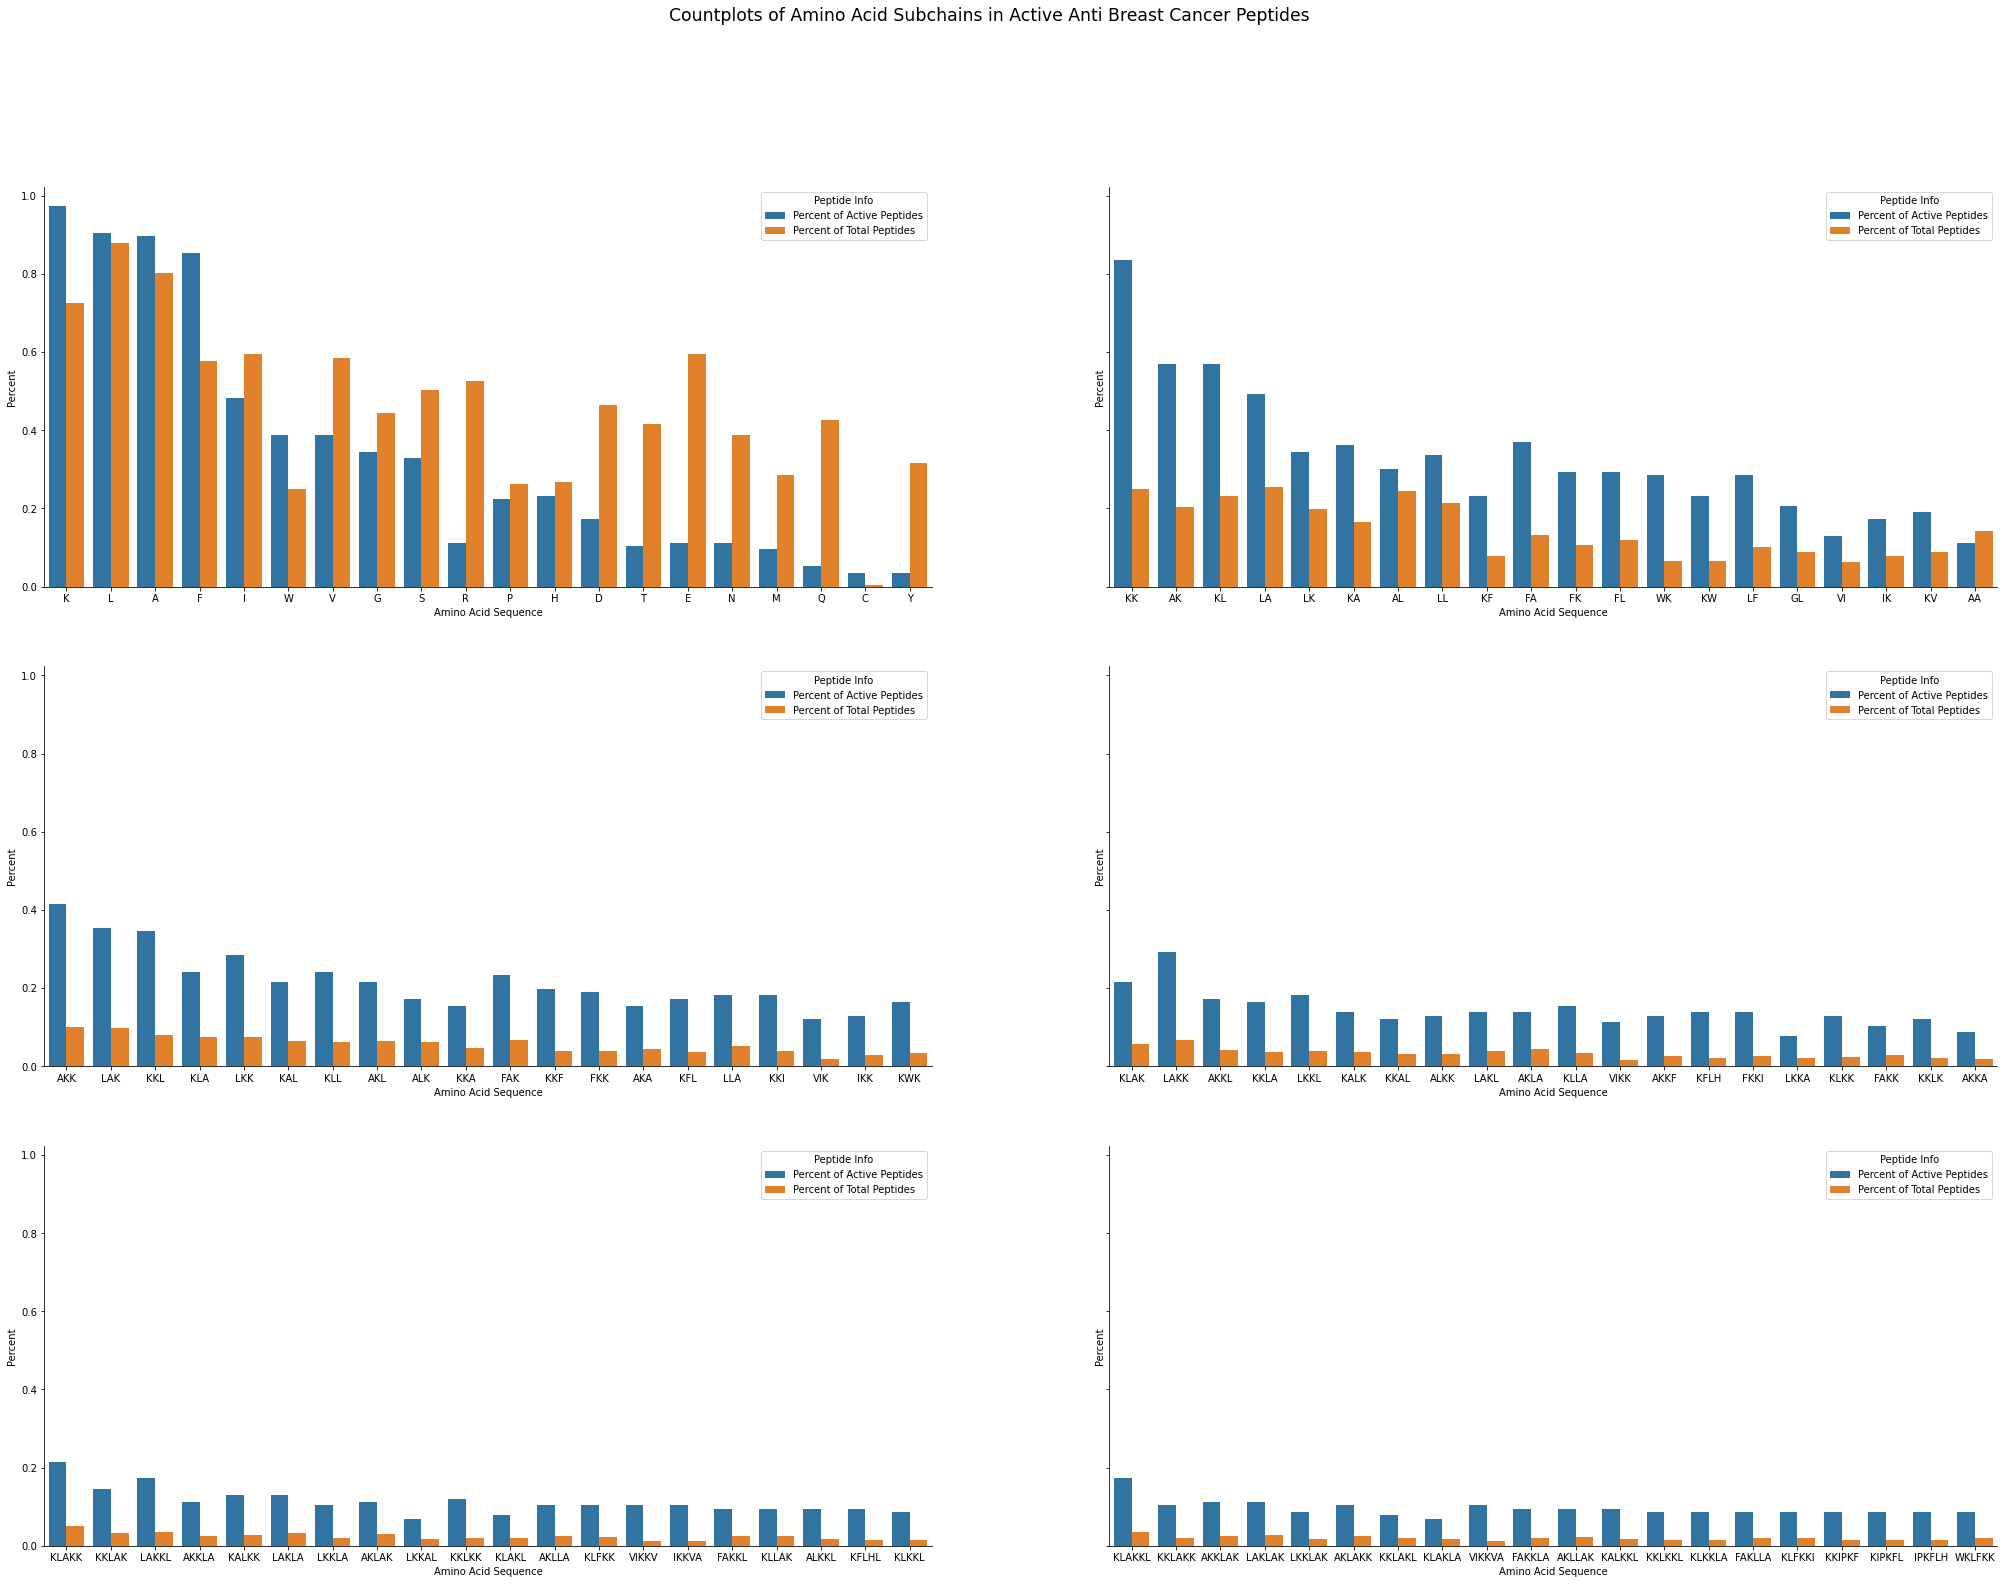

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 2, nrows = 3, figsize=(35, 25), sharey = True)
fig.suptitle('Countplots of Amino Acid Subchains in Active Anti Breast Cancer Peptides', size = 'xx-large')
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_active_plot[:40], ax=ax1[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_active_plot[40:80], ax=ax1[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_active_plot[80:120], ax=ax2[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_active_plot[120:160], ax=ax2[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_active_plot[160:200], ax=ax3[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_active_plot[200:240], ax=ax3[1])
sns.despine(fig)

#Plots the 20 most common subsequences of lengths 1 to 6 in order to compare prevalency in active peptides vs prevalency
#in all peptides. Past subsequences of length 6, the occurence of a specific chain is too low to draw any inferences.

In [36]:
df_breast_inactive_plot = df_breast_inactive_all_data[['Amino Acid Sequence','Percent of Inactive Peptides', 'Percent of Total Peptides']]

array = df_breast_inactive_plot.to_numpy().tolist()
new_array = []
for i in range(len(array)):
    new_array.append([array[i][0], 'Percent of Inactive Peptides', array[i][1]])
    new_array.append([array[i][0], 'Percent of Total Peptides', array[i][2]])
df_breast_inactive_plot = pd.DataFrame(new_array, columns = ['Amino Acid Sequence', 'Peptide Info', 'Percent'])

#Organize the inactive peptide data into a format that can be graphed as a countplot comparing the percent of inactive peptides
#the subsequence is present in, vs the percent of total peptides the subsequence is present in.

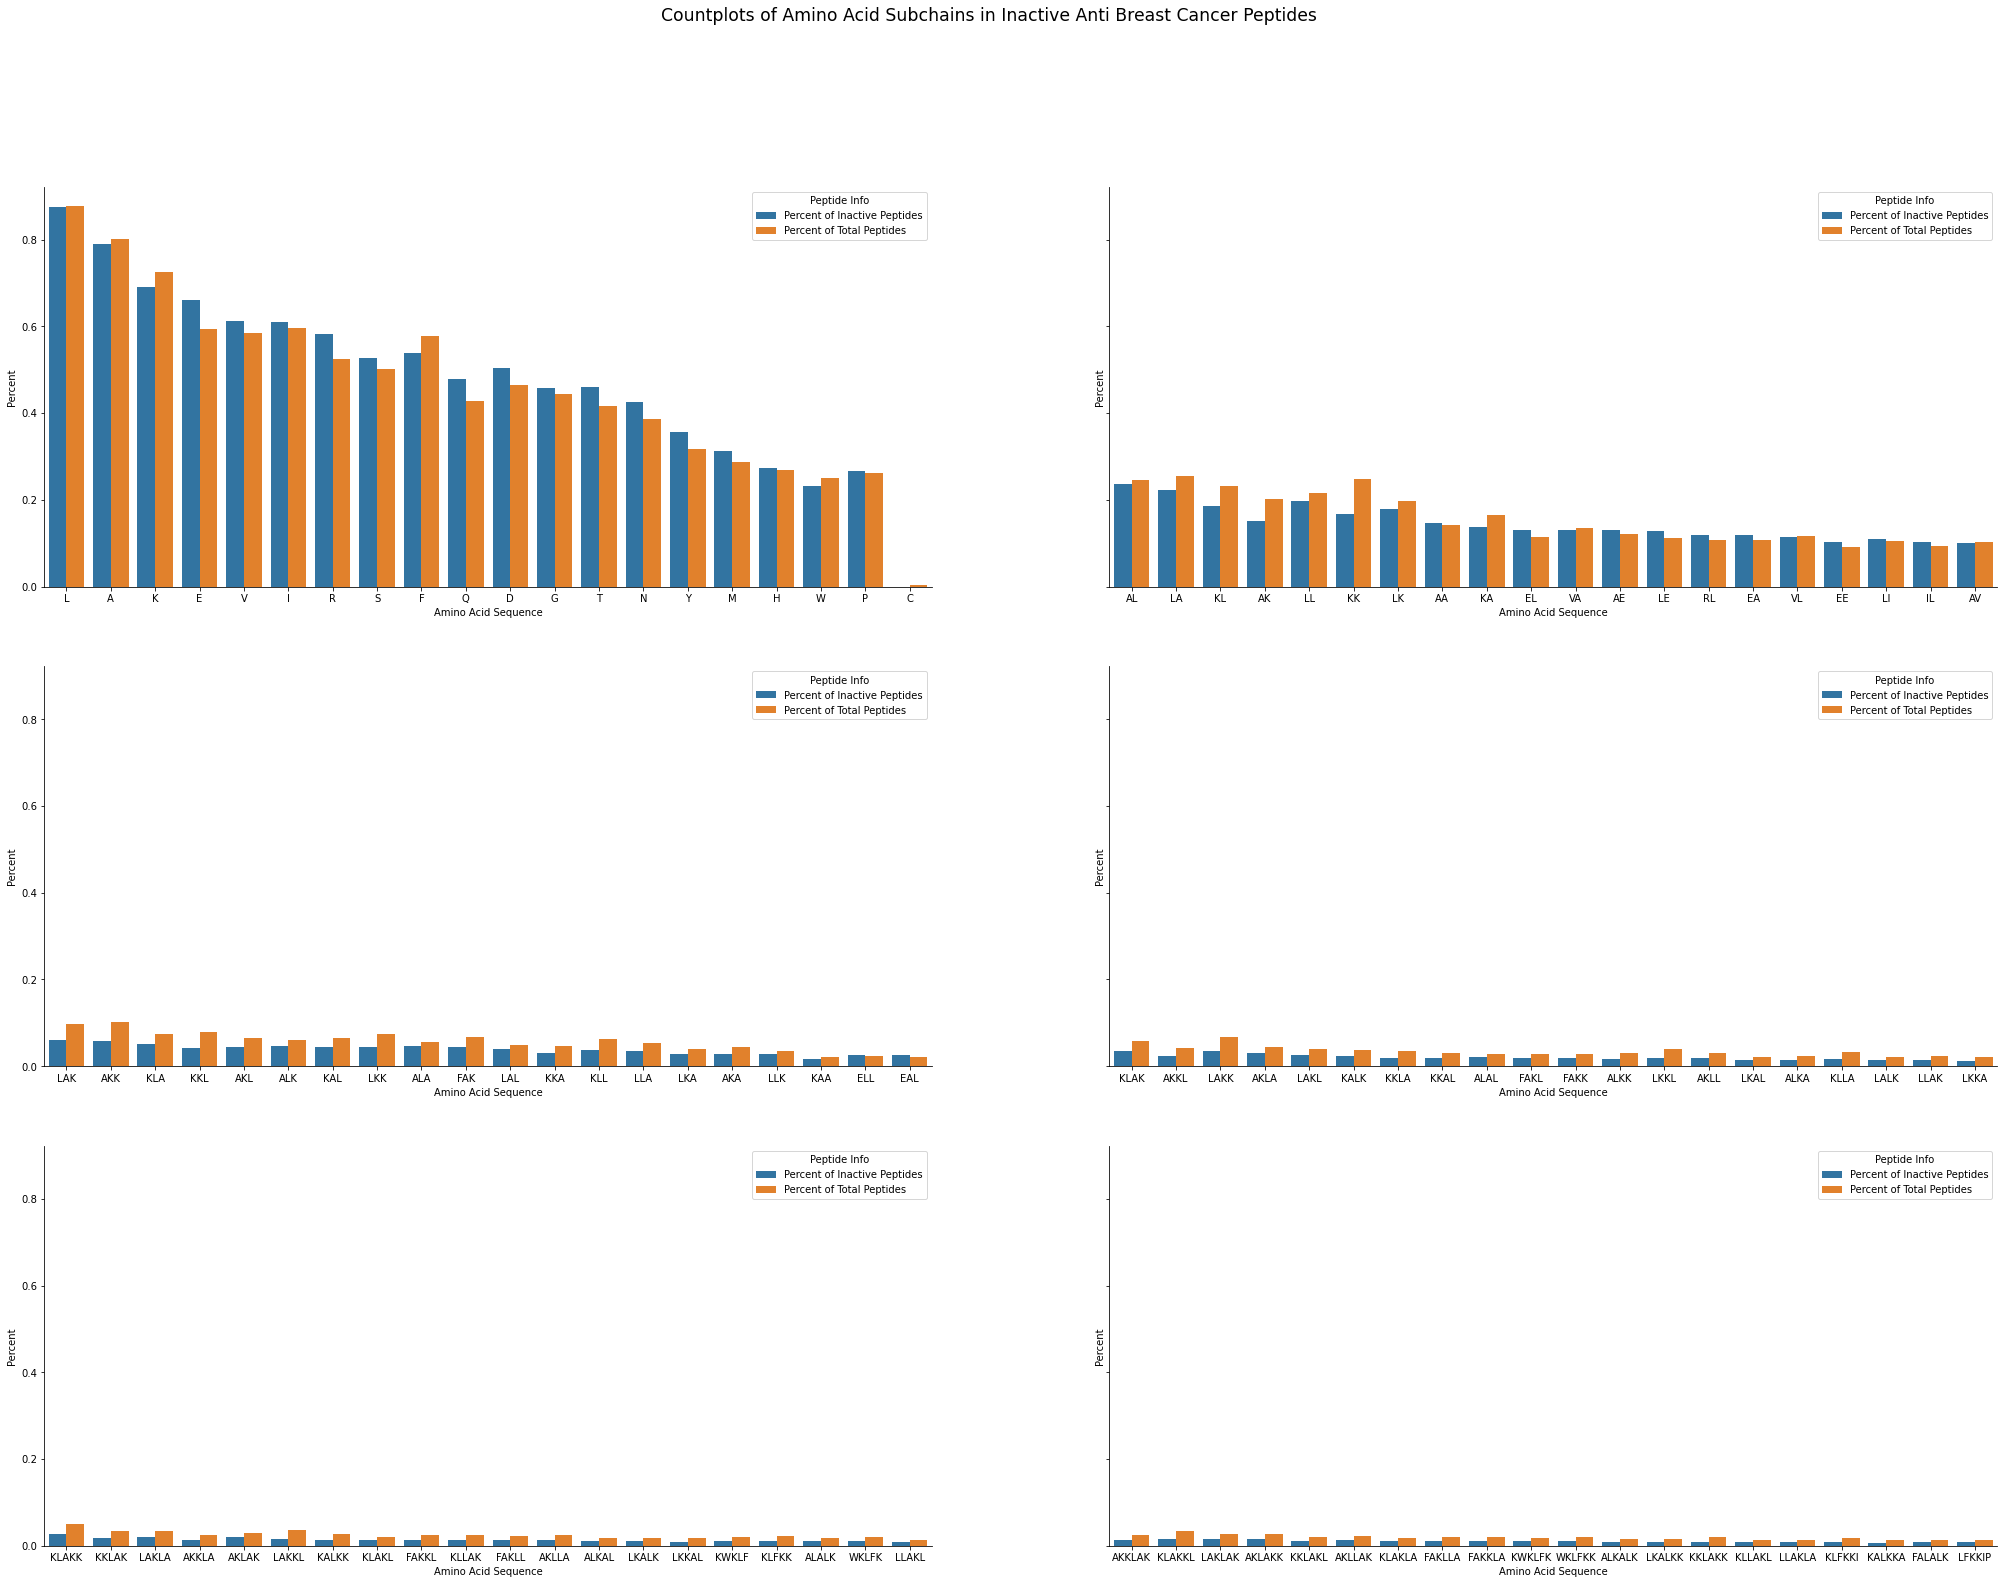

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 2, nrows = 3, figsize=(35, 25), sharey = True)
fig.suptitle('Countplots of Amino Acid Subchains in Inactive Anti Breast Cancer Peptides', size = 'xx-large')
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_inactive_plot[:40], ax=ax1[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_inactive_plot[40:80], ax=ax1[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_inactive_plot[80:120], ax=ax2[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_inactive_plot[120:160], ax=ax2[1])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_inactive_plot[160:200], ax=ax3[0])
sns.barplot(x='Amino Acid Sequence', y='Percent', hue='Peptide Info', data=df_breast_inactive_plot[200:240], ax=ax3[1])
sns.despine(fig)

#Plots the 20 most common subsequences of lengths 1 to 6 in order to compare prevalency in active peptides vs prevalency
#in all peptides. Past subsequences of length 6, the occurence of a specific chain is too low to draw any inferences.

#### With this information in hand, we set out to create a model that can take in a peptide amino acid sequence, and predict whether or not that peptide would have activity against breast and lung cancer.

In [38]:
df_lung_model = copy.deepcopy(df_lung_subsequences_all)

In [39]:
aa_freq_maps = {}

for col in df_lung_model.columns[1:11]: #Loops through the 10 subsequence columns
    df_lung_model=df_lung_model.assign(freq=df_lung_model.groupby(col)[col].transform('count')).sort_values(by=['freq', col],ascending=[False, True]) #Orders the dataframe from most to least occuring amino acid chain
    aa_freq_maps[col]=({0:0},[0])
    occurence = 0
    for val in df_lung_model[col]:
        if val not in aa_freq_maps[col][0]: #If a value is not in the dictionary, adds it and when it was encountered
            occurence +=1
            aa_freq_maps[col][0][val]=occurence
            aa_freq_maps[col][1].append(val)
    df_lung_model.replace({col:aa_freq_maps[col][0]},inplace = True) #Replaces the values in the dataframe with when they were encountered (more common chains will have lower numbers)
    
#Replaces all string data in the lung dataframe with numerical values, with more frequently occuring subchains assigned
#lower numbers.

In [65]:
df_lung_model

,Original Peptide,subsequence_1,subsequence_2,subsequence_3,subsequence_4,subsequence_5,subsequence_6,subsequence_7,subsequence_8,subsequence_9,subsequence_10,Cancer Activity,freq
35,FAKALAKLAKKLL,1,0,0,0,0,0,0,0,0,0,1,8097
50,FAKALKALLKALKAL,1,0,0,0,0,0,0,0,0,0,1,8097
63,FAKFLAKFLKKAL,1,0,0,0,0,0,0,0,0,0,1,8097
79,FAKIIAKIAKIAKKIL,1,0,0,0,0,0,0,0,0,0,0,8097
116,FAKKLAKKLAKAAL,1,0,0,0,0,0,0,0,0,0,0,8097
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14400,TYYAKDIAFQFWKM,15,249,2578,9475,10026,9461,8756,8029,7270,6498,0,1
4900,EDMIFEIFKNYLTKVAYYARQVAEMN,15,249,2578,9476,10027,9462,8757,8030,7271,6499,0,1
12358,SLPEMFDKMRPYYEESKKRVKE,15,249,4238,9477,10028,9463,8758,8031,7272,6500,0,1
5555,EYKYYKLKLAEMQR,15,249,4239,9480,10030,9465,8760,8033,7273,6501,0,1


In [40]:
df_breast_model = copy.deepcopy(df_breast_subsequences_all)

In [41]:
aa_freq_maps = {}

for col in df_breast_model.columns[1:11]: #Loops through the 10 subsequence columns
    df_breast_model=df_breast_model.assign(freq=df_breast_model.groupby(col)[col].transform('count')).sort_values(by=['freq', col],ascending=[False, True]) #Orders the dataframe from most to least occuring amino acid chain
    aa_freq_maps[col]=({0:0},[0])
    occurence = 0
    for val in df_breast_model[col]:
        if val not in aa_freq_maps[col][0]: #If a value is not in the dictionary, adds it and when it was encountered
            occurence +=1
            aa_freq_maps[col][0][val]=occurence
            aa_freq_maps[col][1].append(val)
    df_breast_model.replace({col:aa_freq_maps[col][0]},inplace = True) #Replaces the values in the dataframe with when they were encountered (more common chains will have lower numbers)
    
#Replaces all string data in the breast dataframe with numerical values, with more frequently occuring subchains assigned
#lower numbers.

In [66]:
df_breast_model

,Original Peptide,subsequence_1,subsequence_2,subsequence_3,subsequence_4,subsequence_5,subsequence_6,subsequence_7,subsequence_8,subsequence_9,subsequence_10,Cancer Activity,freq
113,FAKALAKLAKKLL,1,0,0,0,0,0,0,0,0,0,1,8520
128,FAKALKALLKALKAL,1,0,0,0,0,0,0,0,0,0,0,8520
141,FAKFLAKFLKKAL,1,0,0,0,0,0,0,0,0,0,1,8520
157,FAKIIAKIAKIAKKIL,1,0,0,0,0,0,0,0,0,0,0,8520
169,FAKKALKALKKL,1,0,0,0,0,0,0,0,0,0,0,8520
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15220,TYYAKDIAFQFWKM,15,253,2627,9644,10279,9748,9059,8342,7580,6795,0,1
5720,EDMIFEIFKNYLTKVAYYARQVAEMN,15,253,2627,9645,10280,9749,9060,8343,7581,6796,0,1
13178,SLPEMFDKMRPYYEESKKRVKE,15,253,4279,9646,10281,9750,9061,8344,7582,6797,0,1
6375,EYKYYKLKLAEMQR,15,253,4280,9649,10283,9752,9063,8346,7583,6798,0,1


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_selection import RFE

In [43]:
df_lung_model_train = df_lung_model.drop(['Original Peptide', 'freq'], axis = 1)
df_breast_model_train = df_breast_model.drop(['Original Peptide', 'freq'], axis = 1)

#Drop unnecessary columns for model training.

In [44]:
X_RFE_lung = df_lung_model_train.iloc[:, :-1]
y_RFE_lung = df_lung_model_train[['Cancer Activity']]

lr =linear_model.LinearRegression()

rfe = RFE(lr, n_features_to_select=3)

model1=rfe.fit(X_RFE_lung, y_RFE_lung)

print(rfe.support_)
print(rfe.ranking_)

#Determine the best 3 features to use to train the lung data using recursive feature elimination.

[ True  True  True False False False False False False False]
[1 1 1 3 2 5 8 6 7 4]


In [45]:
test_columns_lung = ['subsequence_1', 'subsequence_2', 'subsequence_3']

#The 3 features determined to be best to train the lung model

In [46]:
X_RFE_breast = df_breast_model_train.iloc[:, :-1]
y_RFE_breast = df_breast_model_train[['Cancer Activity']]

lr =linear_model.LinearRegression()

rfe = RFE(lr, n_features_to_select=3)

model1=rfe.fit(X_RFE_breast, y_RFE_breast)

print(rfe.support_)
print(rfe.ranking_)

#Determine the best 3 features to use to train the breast model using recursive feature elimination.

[ True  True  True False False False False False False False]
[1 1 1 4 2 5 7 6 8 3]


In [47]:
test_columns_breast = ['subsequence_1', 'subsequence_2', 'subsequence_3']

#The 3 features determined to be best to train the breast model.

In [48]:
train, test = train_test_split(df_lung_model_train, test_size=0.2, random_state=15, stratify=df_lung_model_train['Cancer Activity'])
train_X_lung = train[test_columns_lung]
train_y_lung = train[train.columns[-1:]]
test_X_lung = test[test_columns_lung]
test_y_lung = test[test.columns[-1:]]
X_lung = df_lung_model_train[test_columns_lung]
y_lung = df_lung_model_train[df_lung_model_train.columns[-1:]]

#Split the lung data into training data and test data. Stratify the data by 'Cancer Activity' to try to preserve the 
#relative frequencies of the activities in the X and y data.

In [49]:
train, test = train_test_split(df_breast_model_train, test_size=0.2, random_state=20, stratify=df_breast_model_train['Cancer Activity'])
train_X_breast = train[test_columns_breast]
train_y_breast = train[train.columns[-1:]]
test_X_breast = test[test_columns_lung]
test_y_breast = test[test.columns[-1:]]
X_breast = df_breast_model_train[test_columns_lung]
y_breast = df_breast_model_train[df_breast_model_train.columns[-1:]]

#Split the breast data into training data and test data. Stratify the data by 'Cancer Activity' to try to preserve the 
#relative frequencies of the activities in the X and y data.

In [50]:
#Linear - SVM - Lung

model = svm.SVC(kernel = 'linear')
model.fit(train_X_lung, train_y_lung)
prediction_SVM_lung = model.predict(test_X_lung)

metrics.accuracy_score(prediction_SVM_lung, test_y_lung)

0.8785263856621308

In [51]:
#Linear - SVM - Breast

model = svm.SVC(kernel = 'linear')
model.fit(train_X_breast, train_y_breast)
prediction_SVM_breast = model.predict(test_X_breast)

metrics.accuracy_score(prediction_SVM_breast, test_y_breast)

0.8643374252439409

In [52]:
#Logistic Regression - Lung

model= LogisticRegression()
model.fit(train_X_lung, train_y_lung)
prediction_Logistic_Regression_lung = model.predict(test_X_lung)

metrics.accuracy_score(prediction_Logistic_Regression_lung, test_y_lung)

0.8785263856621308

In [53]:
#Logistic Regression - Breast

model= LogisticRegression()
model.fit(train_X_breast, train_y_breast)
prediction_Logistic_Regression_breast = model.predict(test_X_breast)

metrics.accuracy_score(prediction_Logistic_Regression_breast, test_y_breast)

0.8643374252439409

In [54]:
#Decision Tree - Lung

model= DecisionTreeClassifier()
model.fit(train_X_lung, train_y_lung)
prediction_Logistic_Regression_lung = model.predict(test_X_lung)

metrics.accuracy_score(prediction_Logistic_Regression_lung, test_y_lung)

0.8831729173581149

In [55]:
#Decision Tree - Breast

model= DecisionTreeClassifier()
model.fit(train_X_breast, train_y_breast)
prediction_Decision_Tree_breast = model.predict(test_X_breast)

metrics.accuracy_score(prediction_Decision_Tree_breast, test_y_breast)

0.8677998111425873

In [56]:
#KNN - Lung

model=KNeighborsClassifier(n_neighbors = 10)
model.fit(train_X_lung, train_y_lung)
prediction_KNN_lung = model.predict(test_X_lung)

metrics.accuracy_score(prediction_KNN_lung, test_y_lung)

0.875871224692997

In [57]:
#KNN - Breast

model=KNeighborsClassifier(n_neighbors = 10)
model.fit(train_X_breast, train_y_breast)
prediction_KNN_breast = model.predict(test_X_breast)

metrics.accuracy_score(prediction_KNN_breast, test_y_breast)

0.8709474346868115

In [58]:
#Gaussian Naive Bayes - Lung

model= GaussianNB()
model.fit(train_X_lung, train_y_lung)
prediction_Gaussian_NB_lung = model.predict(test_X_lung)

metrics.accuracy_score(prediction_Gaussian_NB_lung, test_y_lung)

0.751742449385994

In [59]:
#Gaussian Naive Bayes - Breast

model= GaussianNB()
model.fit(train_X_breast, train_y_breast)
prediction_Gaussian_NB_breast = model.predict(test_X_breast)

metrics.accuracy_score(prediction_Gaussian_NB_breast, test_y_breast)

0.8643374252439409

In [60]:
#Random Forest

model= RandomForestClassifier(n_estimators = 100)
model.fit(train_X_lung, train_y_lung)
prediction_Random_Forest_lung = model.predict(test_X_lung)

metrics.accuracy_score(prediction_Random_Forest_lung, test_y_lung)

0.8818453368735479

In [61]:
#Random Forest

model= RandomForestClassifier(n_estimators = 100)
model.fit(train_X_breast, train_y_breast)
prediction_Random_Forest_breast = model.predict(test_X_breast)

metrics.accuracy_score(prediction_Random_Forest_breast, test_y_breast)

0.8665407617248977